In [1]:
import math
import random
import time

import gym
import numpy as np
import scipy.linalg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
from multiprocessing_env import SubprocVecEnv

num_envs = 64
env_name = "BikeLQR-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

<h2>Neural Network</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [13]:
def plot(frame_idx, rewards):
    clear_output(True)
    #clear_output(False)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('update %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False, init_state=None, nr_steps=int(1e9)):
    if type(init_state) == np.ndarray:
        state = env.reset(init_state=init_state)
    else:
        state = env.reset()
        
    if vis: env.render()
    done = False
    total_reward = 0
    for i in range(nr_steps):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        
        if vis:
            time.sleep(0.1)
            env.render() 
            
        total_reward += reward
        
        if done:
            break
    return total_reward


def test_env_with_certain_initial_conditions(nr_run_throughs=4, 
                                                              phi_ICs=[np.deg2rad(0.5), np.deg2rad(-0.5)],
                                                              v_ICs=[0.5, 5, 10]):
    
    sum_of_cumulative_rewards_for_every_initial_condtition = 0
    
    for i in range(nr_run_throughs):
        for v_0 in v_ICs:
            for phi_0 in phi_ICs:
                init_state = np.array([phi_0, 0, v_0], dtype=np.float32)
                sum_of_cumulative_rewards_for_every_initial_condtition += test_env(init_state=init_state)
    
    nr_of_episodes_tested = nr_run_throughs * len(phi_ICs) * len(v_ICs)
    mean_of_cumulative_rewards_for_every_initial_condtition = 1/nr_of_episodes_tested * sum_of_cumulative_rewards_for_every_initial_condtition
    
    return mean_of_cumulative_rewards_for_every_initial_condtition


def get_phi_sequence(state_0):
    state = state_0.copy()
    phi_sequence = [state[0]]
    delta_sequence = []
    v_sequence = [state[2]]
    done = False
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        phi_sequence.append(next_state[0])
        delta_sequence.append(action)
        v_sequence.append(next_state[2])
        state = next_state.copy()
    return phi_sequence, delta_sequence, v_sequence

<h2>GAE</h2>

In [7]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [8]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [9]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 128
num_steps        = 100
mini_batch_size  = 64
ppo_epochs       = 4
threshold_reward = 10000000

load_optimizer = False # If you have stopped the training and want to resume with the same optimizer parameters
# List of learning rates that will be used as the network crashes:
lr_list = [1e-3, 3e-4, 1e-4, 8e-5, 6e-5, 4e-5, 2e-5, 8e-6, 6e-6, 4e-6, 2e-6]
lr_idx = 0 # Choose which lr in lr_list to start with (note that that it is the index you choose)
lr = lr_list[lr_idx]
# The network has to crash two times with the same learning rate, before the learning rate is changd:
first_crash = True 

# If you like to change the lr according to lr_list when crashes happend. Otherwise you will have to restart and
# reload the best model manually when a crash happens:
changing_learning_rate = False
lr = 9e-6 # If changing_learning_rate False, choose learning rate false

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
max_ppo_updates = 10000
ppo_update_idx  = 0
test_rewards = []
highest_test_reward = -np.inf # Previous highest reward

### Load best network with the optimizer:

In [ ]:
#model.load_state_dict(torch.load('saved_networks/best_network'))
#if load_optimizer:
    #optimizer.load_state_dict(torch.load('saved_networks/optimizer'))

In [11]:
#optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
model.load_state_dict(torch.load('saved_networks/ppo_network_IC_uni_pm5_v_0dot5_to_10_uni_eplen100_lr9e-6_brute_3x128_nodes_ver3'))
#model.load_state_dict(torch.load('saved_networks/checkpoints/checkpoint_idx40_reward-240.43'))
#model.load_state_dict(torch.load('saved_networks/ppo_network_IC_uni_pm0dot5_v_0dot5_to_10_discrete_eplen60_3x128_nodes'))

<All keys matched successfully>

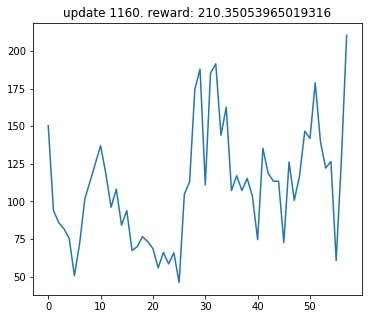

Rewards: [150.29314525395884, 93.92788062662635, 85.89171669222605, 81.77010159539861, 75.41839329109071, 50.603183726792366, 72.13318569200554, 101.85220169958627, 113.37877277015315, 125.22613372552271, 137.01240733411, 118.44050040246596, 96.09831400517496, 108.16222776846983, 84.1696471089352, 93.89623863271197, 67.39384456663751, 69.90994815444243, 76.56545781338227, 73.31450038628832, 68.59079098156893, 55.84017056459794, 66.03360759149749, 58.44919140235377, 65.84959106237713, 46.1203460563121, 104.84883637264068, 112.92524581530765, 174.48620655337555, 187.85205545003183, 110.90994711653623, 185.29909658682632, 191.41215252960336, 144.0075918038133, 162.56139933215286, 107.25741970216822, 117.00492962208831, 107.22567343125851, 115.29921245664647, 103.34843392082632, 74.51959526998965, 135.28208405700227, 118.80103101151164, 113.43902880134867, 113.35539735197322, 72.65345593760443, 126.1447352903405, 100.74581252901719, 116.8988077646034, 146.6706539564442, 141.88749162003484,

KeyboardInterrupt: 

In [13]:
state = envs.reset()
early_stop = False

while ppo_update_idx < max_ppo_updates and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    state = envs.reset()

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
              

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    
    ppo_update_idx += 1
    if ppo_update_idx % 20 == 0:
        #test_reward = np.mean([test_env() for _ in range(64)])
        # nr of episodes used for the test are nr_run_throughs*len(phi_ICs)*len(v_ICs):
        test_reward = test_env_with_certain_initial_conditions(nr_run_throughs=5, 
                                                              phi_ICs=[np.deg2rad(5), np.deg2rad(-5)],
                                                              v_ICs=[0.75, 5.5, 9.5])
        test_rewards.append(test_reward)
        plot(ppo_update_idx, test_rewards)
        print('Rewards:', test_rewards)
        print('Current learning rate:', lr)
        if test_reward > threshold_reward: early_stop = True
        if test_reward > highest_test_reward:
            torch.save(model.state_dict(), 'saved_networks/best_network')
            torch.save(optimizer.state_dict(), 'saved_networks/optimizer')
            highest_test_reward = test_reward
            
        # Checkpoints are saved continously, so not just the best network is solvec:
        torch.save(model.state_dict(), 'saved_networks/checkpoints/checkpoint_idx' + str(ppo_update_idx) + '_reward'
                      +str(round(test_reward,2)))
        
        # Here is the attempt if fixing that the the best network is loaded when a crash happends, and a lower
        # learning rate is chosen:
        if changing_learning_rate == True:
            # If the learning rate is high, then a crash is defined as 600 below the previously best value:
            if lr >= 5e-7:
                if highest_test_reward - test_reward > 600:
                    if first_crash:
                        model.load_state_dict(torch.load('saved_networks/best_network'))
                        if load_optimizer:
                            optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
                        first_crash = False
                    else:
                        model.load_state_dict(torch.load('saved_networks/best_network'))
                        if load_optimizer:
                            optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
                        lr_idx += 1
                        lr = lr_list[np.min([lr_idx, len(lr_list)-1])]
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                        first_crash = True
            # If the learning rate is lower, then a crash is defined as 400 below the previously best value:
            elif lr >= 1e-5:
                if highest_test_reward - test_reward > 400:
                    if first_crash:
                        model.load_state_dict(torch.load('saved_networks/best_network'))
                        if load_optimizer:
                            optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
                        first_crash = False
                    else:
                        model.load_state_dict(torch.load('saved_networks/best_network'))
                        if load_optimizer:
                            optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
                        lr_idx += 1
                        lr = lr_list[np.min([lr_idx, len(lr_list)-1])]
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                        first_crash = True
            # If the learning rate is low, then a crash is defined as 100 below the previously best value:
            else:
                if highest_test_reward - test_reward > 100:
                    if first_crash:
                        model.load_state_dict(torch.load('saved_networks/best_network'))
                        if load_optimizer:
                            optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
                        first_crash = False
                    else:
                        model.load_state_dict(torch.load('saved_networks/best_network'))
                        if load_optimizer:
                            optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
                        lr_idx += 1
                        lr = lr_list[np.min([lr_idx, len(lr_list)-1])]
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                        first_crash = True

### Save and load network

In [13]:
# Save:
#torch.save(model.state_dict(), 'saved_networks/ppo_network')
#torch.save(optimizer.state_dict(), 'saved_networks/optimizer')

# Load:
#model.load_state_dict(torch.load('saved_networks/ppo_network'))
#optimizer.load_state_dict(torch.load('saved_networks/optimizer'))
#model.load_state_dict(torch.load('saved_networks/ppo_network_IC_uni_pm5_v_0dot5_to_10_uni_eplen100_lr9e-6_brute_3x128_nodes'))
#model.load_state_dict(torch.load('saved_networks/checkpoints/checkpoint_idx80_reward181.11'))

### Get average cumulative reward for specified initial conditions:

In [17]:
test_env_with_certain_initial_conditions(nr_run_throughs=4, 
                                        phi_ICs=[np.deg2rad(0.5), np.deg2rad(-0.5)],
                                        v_ICs=[0.75, 5.5, 9.5])

146.1245199218605

In [13]:
test_env_with_certain_initial_conditions(nr_run_throughs=4, 
                                        phi_ICs=[np.deg2rad(5), np.deg2rad(-5)],
                                        v_ICs=[0.75, 5.5, 9.5])

175.04892393180455

### Get average cumulative reward

In [16]:
test_reward = np.mean([test_env() for _ in range(200)])
test_reward

238.73060067394647

### Render

In [18]:
init_state = np.array([np.deg2rad(-5), 0, 1], dtype=np.float32)
nr_steps_to_render = 30
test_env(vis=True, init_state=init_state, nr_steps=nr_steps_to_render)
env.close()

### Plot sequnce

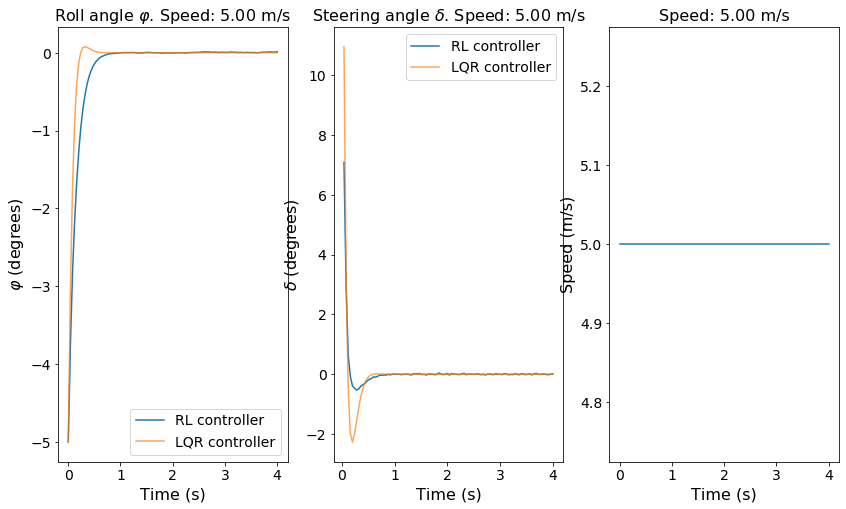

In [16]:
changing_speed = False
init_state = np.array([np.deg2rad(-5), 0, 5],dtype=np.float32)
state_0 = env.reset(init_state=init_state, changing_speed  = changing_speed)
phi_sequence, delta_sequence, velocity = get_phi_sequence(state_0)

Ts = 0.04
t = np.arange(0, len(phi_sequence)*Ts, Ts)
fig, axes = plt.subplots(1, 3, figsize=(14,8))


axes[0].plot(t, np.rad2deg(phi_sequence), label = "RL controller")
axes[0].set_xlabel('Time (s)', fontsize = 16)
axes[0].set_ylabel(r'$\varphi$ (degrees)', fontsize = 16)
axes[0].set_title(r'Roll angle $\varphi$. Speed: {:.2f} m/s'.format(state_0[2]), fontsize=16)
axes[0].tick_params(axis="x", labelsize=14)
axes[0].tick_params(axis="y", labelsize=14)


axes[1].plot(t[1:], np.rad2deg(delta_sequence), label="RL controller")
axes[1].set_xlabel('Time (s)', fontsize = 16)
axes[1].set_ylabel('$\delta$ (degrees)', fontsize = 16)
axes[1].set_title('Steering angle $\delta$. Speed: {:.2f} m/s'.format(state_0[2]), fontsize = 16);
axes[1].tick_params(axis="x", labelsize=14)
axes[1].tick_params(axis="y", labelsize=14)


axes[2].plot(t, velocity)
axes[2].set_xlabel('Time (s)', fontsize = 16)
axes[2].set_ylabel('Speed (m/s)', fontsize = 16)
axes[2].set_title('Speed: {:.2f} m/s'.format(state_0[2]), fontsize = 16);
axes[2].tick_params(axis="x", labelsize=14)
axes[2].tick_params(axis="y", labelsize=14)

# Plotting the optimal sequences as well (they come from using the K gain from the dlqr algorithm)
from utility_functions import get_optimal_sequence
optimal_phi_sequence, optimal_delta_sequence = get_optimal_sequence(init_state, env, changing_speed = changing_speed)
t_optimal = np.arange(0, len(optimal_phi_sequence)*Ts, Ts)

axes[0].plot(t_optimal, np.rad2deg(optimal_phi_sequence), alpha=0.7, label = "LQR controller")
axes[0].legend(fontsize=14)
axes[1].plot(t_optimal[1:], np.rad2deg(optimal_delta_sequence), alpha=0.7, label="LQR controller")
axes[1].legend(fontsize=14);

<h1>Saving trajectories for GAIL</h1>

In [87]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)

episode: 0 reward: -133.5056485070341
episode: 1 reward: -3.3737309166625002
episode: 2 reward: -135.0328820133956
episode: 3 reward: -131.27964142064513
episode: 4 reward: -125.12845453838382
episode: 5 reward: -4.247933460422459
episode: 6 reward: -395.59297834503883
episode: 7 reward: -253.25736991568547
episode: 8 reward: -135.50603026103278
episode: 9 reward: -132.72095459732952
episode: 10 reward: -133.89608385869212
episode: 11 reward: -4.5990508813314035
episode: 12 reward: -134.44470210766775
episode: 13 reward: -801.7661346371387
episode: 14 reward: -131.97725229377644
episode: 15 reward: -266.76940521674015
episode: 16 reward: -247.5062278004002
episode: 17 reward: -4.914595620774103
episode: 18 reward: -138.7990887577753
episode: 19 reward: -268.3754189751262
episode: 20 reward: -363.28764882256417
episode: 21 reward: -128.15870842354997
episode: 22 reward: -134.94598918501788
episode: 23 reward: -309.9577786212293
episode: 24 reward: -131.91670030817002
episode: 25 reward: